# Common mistakes

## 1. Creating cells without `cell` decorator

The cell decorator names cells deterministically and uniquely based on the name of the functions and its parameters.

It also uses a caching mechanisms that improves performance and guards against duplicated names.

### 1.1 naming cells manually

Naming cells manually is susceptible to name collisions

in GDS you can't have two cells with the same name.

For example: this code will raise a `duplicated cell name ValueError`

```python
import gdsfactory as gf

c1 = gf.Component("wg")
c1 << gf.components.straight(length=5)


c2 = gf.Component("wg")
c2 << gf.components.straight(length=50)


c3 = gf.Component("waveguides")
wg1 = c3 << c1
wg2 = c3 << c2
wg2.movey(10)
c3
```

**Solution**: Use the `gf.cell` decorator for automatic naming your components.

In [1]:
import gdsfactory as gf


@gf.cell
def wg(length: float = 3):
    return gf.components.straight(length=length)


print(wg(length=5))
print(wg(length=50))

2023-01-22 16:13:36.007 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.23.4


2023-01-22 16:13:36.837 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/klayout/tech/layers.lyp.


wg_length5: uid 5b14de8e, ports ['o1', 'o2'], references [], 1 polygons
wg_length50: uid 33fbf8a6, ports ['o1', 'o2'], references [], 1 polygons


### 1.2 Not naming components with a unique and deterministic name

In the case of not wrapping the function with `cell` you will get unique names thanks to the unique identifier `uuid`.

This name will be different and non-deterministic for different invocations of the script.

However it will be hard for you to know where that cell came from.

In [2]:
c1 = gf.Component()
c2 = gf.Component()

print(c1.name)
print(c2.name)

Unnamed_aa59b40e
Unnamed_0b490661


Notice how gdsfactory raises a Warning when you save this `Unnamed` Components

In [3]:
c1.write_gds()

/home/runner/work/gdsfactory/gdsfactory/gdsfactory/component.py:1522: UserWarning: Component 'Unnamed_aa59b40e' contains 1 Unnamed cells
  warnings.warn(
2023-01-22 16:13:36.906 | INFO     | gdsfactory.component:_write_library:1538 - Wrote to '/tmp/tmp7nimtl_a/gdsfactory/Unnamed_aa59b40e.gds'


PosixPath('/tmp/tmp7nimtl_a/gdsfactory/Unnamed_aa59b40e.gds')

### 1.3 Intermediate Unnamed cells

While creating a cell, you should not create intermediate cells, because they won't get a name.

/home/runner/work/gdsfactory/gdsfactory/gdsfactory/component.py:1522: UserWarning: Component 'die_bad' contains 1 Unnamed cells
  warnings.warn(


[ComponentReference (parent Component "Unnamed_3255168e", ports [], origin (-5.0, 0.0), rotation 0.0, x_reflection False)]


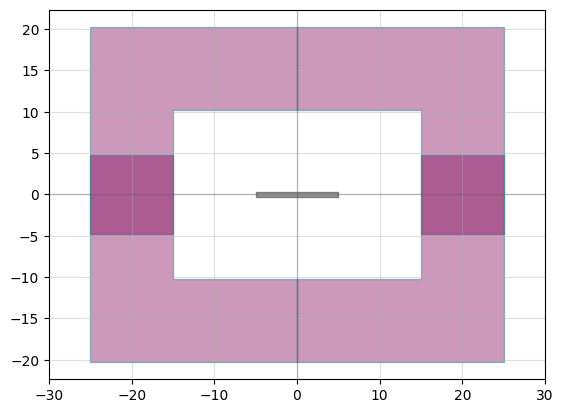

die_bad: uid a3b874be, ports [], references ['Unnamed_3255168e_1'], 4 polygons

In [4]:
@gf.cell
def die_bad():
    """c1 is an intermediate Unnamed cell"""
    c1 = gf.Component()
    c1 << gf.components.straight(length=10)
    c2 = gf.components.die_bbox(c1, street_width=10)
    return c2


c = die_bad(cache=False)
print(c.references)
c

**Solution1** Don't use intermediate cells

[ComponentReference (parent Component "straight_length10", ports ['o1', 'o2'], origin (0.0, 0.0), rotation 0.0, x_reflection False), ComponentReference (parent Component "die_bbox_frame_de250f4c", ports [], origin (0.0, 0.0), rotation 0.0, x_reflection False)]


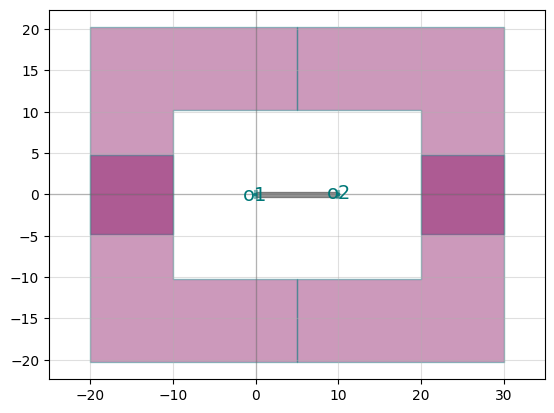

die_good: uid 3751916b, ports [], references ['straight_1', 'die_bbox_frame_1'], 0 polygons

In [5]:
@gf.cell
def die_good():
    c = gf.Component()
    c << gf.components.straight(length=10)
    c << gf.components.die_bbox_frame(c.bbox, street_width=10)
    return c


c = die_good(cache=False)
print(c.references)
c

**Solution2** You can flatten the cell, but you will lose the memory savings from cell references. Solution1 is more elegant.

[]


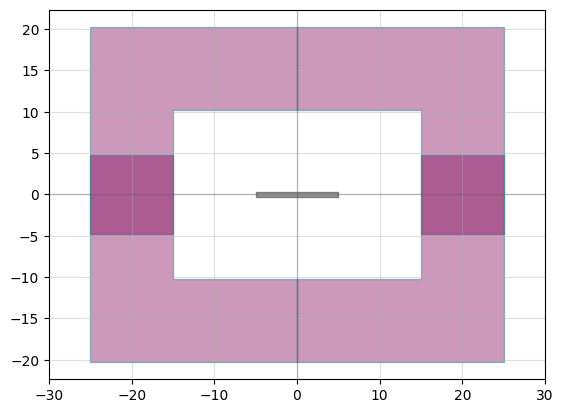

die_flat: uid 7a22b437, ports [], references [], 5 polygons

In [6]:
@gf.cell
def die_flat():
    """c will be an intermediate unnamed cell"""
    c = gf.Component()
    c << gf.components.straight(length=10)
    c2 = gf.components.die_bbox(c, street_width=10)
    c2 = c2.flatten()
    return c2


c = die_flat(cache=False)
print(c.references)
c